## Observations and Insights 

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mouse_merge_df = pd.merge(left=mouse_metadata,right=study_results,on='Mouse ID')

In [3]:
# Checking the number of mice in the DataFrame.
mouse_unique = mouse_merge_df["Mouse ID"].nunique()

In [4]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
mouse_merge_dupe_df = mouse_merge_df[mouse_merge_df.duplicated(keep='first')]
mouse_merge_dupe_df[["Mouse ID", "Timepoint"]]

,Mouse ID,Timepoint
909,g989,0


In [5]:
# Optional: Get all the data for the duplicate mouse ID. 
mouse_merge_dupe_df = mouse_merge_df[mouse_merge_df.duplicated(keep='first')]
mouse_merge_dupe_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
909,g989,Propriva,Female,21,26,0,45.0,0


In [6]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
mouse_merge_clean_df = mouse_merge_df.drop_duplicates()
mouse_merge_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [7]:
# Checking the number of mice in the clean DataFrame. 
assert mouse_merge_df["Mouse ID"].nunique() == mouse_unique


## Summary Statistics

In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# This method is the most straightforward, creating multiple series and putting them all together at the end.
mm_group_mean_df = mouse_merge_clean_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].mean()
mm_group_median_df = mouse_merge_clean_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].median()
mm_group_var_df = mouse_merge_clean_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].var()
mm_group_std_df = mouse_merge_clean_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].std()
mm_group_sem_df = mouse_merge_clean_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].sem()

In [43]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Create a dictionary to hold the results
summary_dict = {"Mean": mm_group_mean_df.map('{:.2f}'.format), 
                "Median": mm_group_median_df.map('{:.2f}'.format), 
                "Variance": mm_group_var_df.map('{:.2f}'.format), 
                "Standard Deviation": mm_group_std_df.map('{:.2f}'.format), 
                "SEM": mm_group_sem_df.map('{:.2f}'.format)
               }
# Use the dictionary in a new dataframe
summary_new_df = pd.DataFrame(data=summary_dict)
summary_new_df

,Mean,Median,Variance,Standard Deviation,SEM
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.33
Ceftamin,52.59,51.78,39.29,6.27,0.47
Infubinol,52.88,51.82,43.13,6.57,0.49
Ketapril,55.24,53.70,68.55,8.28,0.60
Naftisol,54.33,52.51,66.17,8.13,0.60
Placebo,54.03,52.29,61.17,7.82,0.58
Propriva,52.37,50.91,42.28,6.50,0.51
Ramicane,40.22,40.67,23.49,4.85,0.32
Stelasyn,54.23,52.43,59.45,7.71,0.57


## Bar Plots

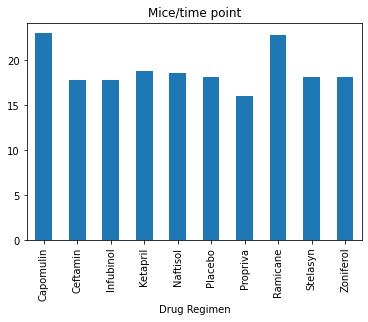

In [11]:
# Generate a bar plot showing the number of mice per time point for each treatment throughout the course of the study using pandas.
# Calculate number of mice / timepoint for each treatment
mm_group_mouse_per_tp_df = mouse_merge_clean_df.groupby(["Drug Regimen"])["Mouse ID"].count() / len(mouse_merge_clean_df.groupby(["Drug Regimen"])["Mouse ID"])
mm_group_mouse_per_tp_df.plot.bar(title='Mice/time point')
plt.show()

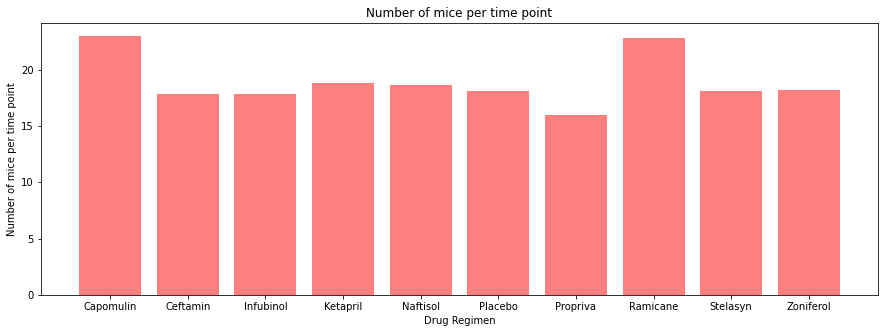

In [12]:
# Generate a bar plot showing the number of mice per time point for each treatment throughout the course of the study using pyplot.
x_axis = mm_group_mouse_per_tp_df.index
plt.figure(figsize=(15,5))
plt.bar(x_axis, 
        mm_group_mouse_per_tp_df, 
        color='r', 
        alpha = 0.5, 
        align = 'center'
       )
# Set title and x, y axis labels
plt.title("Number of mice per time point")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of mice per time point")
plt.show()

## Pie Plots

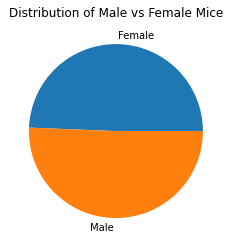

In [13]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
# Create count of male vs female mice
mouse_mf_df = mouse_merge_clean_df.groupby(["Sex"])["Mouse ID"].count()
mouse_mf_df.plot(kind='pie',title='Distribution of Male vs Female Mice',ylabel='')
plt.show()

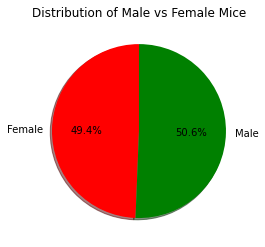

In [14]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
labels = mouse_mf_df.index
colors = ['red','green']
plt.title("Distribution of Male vs Female Mice")
plt.pie(mouse_mf_df,
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",
        shadow=True,
        startangle=90
       )
plt.show()

## Quartiles, Outliers and Boxplots

In [23]:
# Calculate the final tumor volume of each mouse across four of the most promising treatment regimens. Calculate the IQR and quantitatively determine if there are any potential outliers. 
# Filter the dataset to obtain the final tumor volume (timepoint = 45) for each mouse, grouped by regimen
final_time = max(mouse_merge_df["Timepoint"])
mouse_merge1_df = mouse_merge_clean_df.loc[mouse_merge_clean_df["Timepoint"] == final_time]

# Compute the average tumor volume for each regimen and sort them to find the top 4 selected as those with the lowest average tumor volume
top_regimen = 4
mouse_top_df = mouse_merge1_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"] \
                .mean().reset_index().sort_values(by="Tumor Volume (mm3)").reset_index(drop=True)
mouse_top4_df = mouse_top_df[:top_regimen]

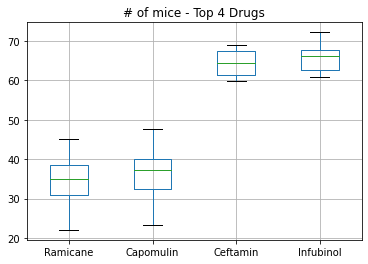

In [36]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
# use a dictionary comprehension
mouse_dict = {drug:mouse_merge1_df["Tumor Volume (mm3)"].loc[mouse_merge1_df["Drug Regimen"] == drug] for drug in mouse_top4_df['Drug Regimen'].values}   
pd.DataFrame.from_dict(mouse_dict).boxplot().set_title("# of mice - Top 4 Drugs")
plt.show()

In [57]:
# Lower quartiles
lower_q = {k: np.percentile(v, 25) for k, v in mouse_dict.items()}
lower_q

{'Ramicane': 30.981175224999998,
 'Capomulin': 32.37735684,
 'Ceftamin': 61.43389223,
 'Infubinol': 62.75445141}

In [58]:
# Upper quartiles
upper_q = {k: np.percentile(v, 75) for k, v in mouse_dict.items()}
upper_q

{'Ramicane': 38.5083053075,
 'Capomulin': 40.1592203,
 'Ceftamin': 67.52748237,
 'Infubinol': 67.68556862}

In [60]:
# IQR / Interquartile range
iqr = {key: upper_q[key] - lower_q.get(key,0) for key in upper_q.keys()}
iqr

{'Ramicane': 7.527130082500005,
 'Capomulin': 7.781863460000004,
 'Ceftamin': 6.093590140000003,
 'Infubinol': 4.9311172099999965}

In [61]:
# Lower bound
lower_bound = {key: lower_q[key] - 1.5*iqr.get(key,0) for key in lower_q.keys()}
lower_bound

{'Ramicane': 19.69048010124999,
 'Capomulin': 20.70456164999999,
 'Ceftamin': 52.29350701999999,
 'Infubinol': 55.35777559500001}

In [63]:
# Upper bound
upper_bound = {key: upper_q[key] + 1.5*iqr.get(key,0) for key in upper_q.keys()}
upper_bound

{'Ramicane': 49.79900043125001,
 'Capomulin': 51.83201549,
 'Ceftamin': 76.66786758,
 'Infubinol': 75.08224443499999}

In [64]:
# Lower bound potential outliers
print(f"Values below {lower_bound} could be outliers.")

Values below {'Ramicane': 19.69048010124999, 'Capomulin': 20.70456164999999, 'Ceftamin': 52.29350701999999, 'Infubinol': 55.35777559500001} could be outliers.


In [66]:
# Upper bound potential outliers
print(f"Values above {upper_bound} could be outliers.")

Values above {'Ramicane': 49.79900043125001, 'Capomulin': 51.83201549, 'Ceftamin': 76.66786758, 'Infubinol': 75.08224443499999} could be outliers.


## Line and Scatter Plots

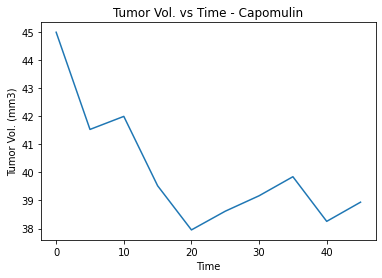

In [21]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
mouse_ID = 'b742'  # NB pick the first row
regimen = 'Capomulin'
capomulin_df = mouse_merge_clean_df.loc[(mouse_merge_clean_df["Drug Regimen"] == regimen) & (mouse_merge_clean_df["Mouse ID"] == mouse_ID)][["Timepoint", 'Tumor Volume (mm3)']].set_index("Timepoint")
plt.xlabel(xlabel="Time")
plt.ylabel(ylabel="Tumor Vol. (mm3)")
plt.title(f"Tumor Vol. vs Time - {regimen}")
plt.plot(capomulin_df)
plt.show()

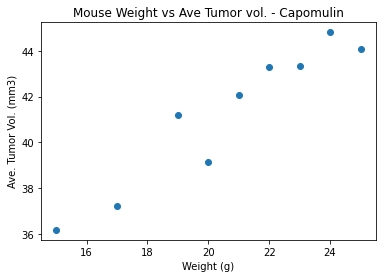

In [22]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
capomulin_wt_df = mouse_merge_clean_df.loc[(mouse_merge_clean_df["Drug Regimen"] == regimen)][["Weight (g)", 'Tumor Volume (mm3)']].set_index("Weight (g)").groupby(by="Weight (g)").mean()
plt.title(f"Mouse Weight vs Ave Tumor vol. - {regimen}")
plt.xlabel("Weight (g)")
plt.ylabel("Ave. Tumor Vol. (mm3)")
x_axis_wt = capomulin_wt_df.index
y_axis_wt = capomulin_wt_df['Tumor Volume (mm3)']
plt.scatter(x_axis_wt, y_axis_wt)
plt.show()

## Correlation and Regression

In [42]:
# Calculate the correlation coefficient and linear regression model for mouse weight and average tumor volume for the Capomulin regimen
# Correlation coef
correlation = stats.pearsonr(x_axis_wt,y_axis_wt)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is 0.95


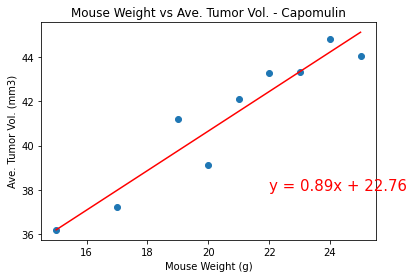

In [35]:
# Perform linear regression
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_axis_wt, y_axis_wt) 
# Get x/y values for linear regression linear
regress_values = x_axis_wt * slope + intercept                                        
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_axis_wt,y_axis_wt)
# Add linear regression line to plot
plt.plot(x_axis_wt,regress_values,"r-")
# Choose data points which are inside the graph to obtain the equation.
plt.annotate(line_eq,(22,38),fontsize=15,color="red")                                 
plt.title(f'Mouse Weight vs Ave. Tumor Vol. - {regimen}')
plt.xlabel('Mouse Weight (g)')
plt.ylabel('Ave. Tumor Vol. (mm3)')
plt.show()